In [41]:
# ================== 1. Import ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import time, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(">>> Đang sử dụng:", device)
if device.type == "cuda":
    print(">>> GPU:", torch.cuda.get_device_name(0))

# ================== 2. Data ==================
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 👉 dataset bây giờ chỉ có 2 class: "pallet" và "nothing"
train_dir = "dataset_step1/images/train"
val_dir   = "dataset_step1/images/val"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# ================== 3. Model ==================
modelA = models.efficientnet_b0(pretrained=True)
num_ftrs = modelA.classifier[1].in_features
modelA.classifier[1] = nn.Linear(num_ftrs, len(class_names))
modelA = modelA.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modelA.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ================== 4. Training ==================
best_acc, patience, trigger = 0.0, 5, 0
for epoch in range(30):
    start = time.time()
    # Train
    modelA.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = modelA(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    train_acc = train_correct / train_total
    train_loss = train_loss / train_total
    # Val
    modelA.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = modelA(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    val_loss = val_loss / val_total
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Train loss: {train_loss: .4f} | Val Acc: {val_acc:.4f} | Time: {time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(modelA.state_dict(), "pallet_detector.pth")
        print("✅ Saved new best model")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping")
            break

print("Best Val Acc (Detector):", best_acc)


>>> Đang sử dụng: cuda:0
>>> GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Classes: ['nothing', 'pallet']


d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | Train Acc: 0.6535 | Train loss:  0.6559 | Val Acc: 0.5000 | Time: 12.1s
✅ Saved new best model
Epoch 02 | Train Acc: 0.8218 | Train loss:  0.5633 | Val Acc: 0.7500 | Time: 10.4s
✅ Saved new best model
Epoch 03 | Train Acc: 0.9505 | Train loss:  0.4679 | Val Acc: 0.8125 | Time: 10.4s
✅ Saved new best model
Epoch 04 | Train Acc: 0.9307 | Train loss:  0.3934 | Val Acc: 0.8125 | Time: 10.9s
Epoch 05 | Train Acc: 0.9802 | Train loss:  0.3359 | Val Acc: 0.8750 | Time: 10.4s
✅ Saved new best model
Epoch 06 | Train Acc: 0.9901 | Train loss:  0.2941 | Val Acc: 0.8750 | Time: 10.1s
Epoch 07 | Train Acc: 1.0000 | Train loss:  0.2657 | Val Acc: 0.9375 | Time: 10.3s
✅ Saved new best model
Epoch 08 | Train Acc: 0.9901 | Train loss:  0.2608 | Val Acc: 0.9375 | Time: 10.6s
Epoch 09 | Train Acc: 0.9802 | Train loss:  0.2677 | Val Acc: 0.8750 | Time: 10.7s
Epoch 10 | Train Acc: 0.9802 | Train loss:  0.2384 | Val Acc: 0.8750 | Time: 10.8s
Epoch 11 | Train Acc: 1.0000 | Train loss:  0.2428 | Va

In [2]:
# ================== 1. Import ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import time, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(">>> Đang sử dụng:", device)
if device.type == "cuda":
    print(">>> GPU:", torch.cuda.get_device_name(0))

# ================== 2. Data ==================
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 👉 dataset bây giờ chỉ có 2 class: "empty_pallet", "loaded_pallet"
train_dir = "dataset_step2/images/train"
val_dir   = "dataset_step2/images/val"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# ================== 3. Model ==================
modelB = models.efficientnet_b3(pretrained=True)
num_ftrs = modelB.classifier[1].in_features
modelB.classifier[1] = nn.Linear(num_ftrs, len(class_names))
modelB = modelB.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modelB.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ================== 4. Training ==================
best_acc, patience, trigger = 0.0, 5, 0
for epoch in range(30):
    start = time.time()
    # Train
    modelB.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = modelB(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    train_acc = train_correct / train_total

    # Val
    modelB.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = modelB(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(modelB.state_dict(), "pallet_classifier.pth")
        print("✅ Saved new best model")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping")
            break

print("Best Val Acc (Classifier):", best_acc)


>>> Đang sử dụng: cuda:0
>>> GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Classes: ['empty_pallet', 'loaded_pallet']
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\ducho/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 47.2M/47.2M [00:08<00:00, 5.78MB/s]


Epoch 01 | Train Acc: 0.4545 | Val Acc: 0.5714 | Time: 13.8s
✅ Saved new best model
Epoch 02 | Train Acc: 0.7403 | Val Acc: 0.7857 | Time: 11.2s
✅ Saved new best model
Epoch 03 | Train Acc: 0.8052 | Val Acc: 0.7857 | Time: 11.0s
Epoch 04 | Train Acc: 0.8701 | Val Acc: 0.7857 | Time: 10.6s
Epoch 05 | Train Acc: 0.8961 | Val Acc: 0.8571 | Time: 11.1s
✅ Saved new best model
Epoch 06 | Train Acc: 0.9091 | Val Acc: 0.9286 | Time: 11.0s
✅ Saved new best model
Epoch 07 | Train Acc: 0.9351 | Val Acc: 0.8571 | Time: 11.1s
Epoch 08 | Train Acc: 0.9351 | Val Acc: 0.8571 | Time: 10.9s
Epoch 09 | Train Acc: 0.9610 | Val Acc: 0.9286 | Time: 10.9s
Epoch 10 | Train Acc: 0.9610 | Val Acc: 0.9286 | Time: 11.0s
Epoch 11 | Train Acc: 0.9481 | Val Acc: 0.9286 | Time: 10.9s
⏹ Early stopping
Best Val Acc (Classifier): 0.9285714285714286


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# ---- Step 1: Load models ----
def load_model_efficientnet(num_classes, weight_path):
    model = models.efficientnet_b0(pretrained=False)

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    state_dict = torch.load(weight_path, map_location="cpu")
    model.load_state_dict(state_dict)
    model.eval()
    return model

# model1: Có pallet hay không
model1 = load_model_efficientnet(2, "pallet_detector.pth")

# model2: Empty pallet vs Loaded pallet
model2 = load_model_efficientnet(2, "pallet_classifier.pth")

# ---- Step 2: Preprocessing ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Step 3: Inference Pipeline ----
def infer_pipeline(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0)  # (1, C, H, W)

    with torch.no_grad():
        # Step 1: Pallet vs Nothing
        out1 = model1(x)
        prob1 = torch.softmax(out1, dim=1)
        pred1 = torch.argmax(prob1, dim=1).item()

    if pred1 == 0:  
        return {"label": "No Pallet", "confidence": prob1[0][0].item()}
    else:
        with torch.no_grad():
            # Step 2: Empty vs Loaded
            out2 = model2(x)
            prob2 = torch.softmax(out2, dim=1)
            pred2 = torch.argmax(prob2, dim=1).item()

        if pred2 == 0:
            return {"label": "Empty Pallet", "confidence": prob2[0][0].item()}
        else:
            return {"label": "Loaded Pallet", "confidence": prob2[0][1].item()}

# ---- Test thử ----
for i in range (1, 10):
    result = infer_pipeline(f"D:\LAB\{i}.jpg")
    print("Result:", result)
# result = infer_pipeline(r"D:\LAB\nothing.jpg")
# print("Result:", result)

<string>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\L'
<string>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\{'
<>:57: SyntaxWarning: invalid escape sequence '\L'
C:\Users\ducho\AppData\Local\Temp\ipykernel_17664\2091105903.py:57: SyntaxWarning: invalid escape sequence '\{'
  result = infer_pipeline(f"D:\LAB\{i}.jpg")
C:\Users\ducho\AppData\Local\Temp\ipykernel_17664\2091105903.py:57: SyntaxWarning: invalid escape sequence '\L'
  result = infer_pipeline(f"D:\LAB\{i}.jpg")
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LAB\2025_Pallet_Demo\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` fo

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.1.1.block.0.0.weight", "features.1.1.block.0.1.weight", "features.1.1.block.0.1.bias", "features.1.1.block.0.1.running_mean", "features.1.1.block.0.1.running_var", "features.1.1.block.1.fc1.weight", "features.1.1.block.1.fc1.bias", "features.1.1.block.1.fc2.weight", "features.1.1.block.1.fc2.bias", "features.1.1.block.2.0.weight", "features.1.1.block.2.1.weight", "features.1.1.block.2.1.bias", "features.1.1.block.2.1.running_mean", "features.1.1.block.2.1.running_var", "features.2.2.block.0.0.weight", "features.2.2.block.0.1.weight", "features.2.2.block.0.1.bias", "features.2.2.block.0.1.running_mean", "features.2.2.block.0.1.running_var", "features.2.2.block.1.0.weight", "features.2.2.block.1.1.weight", "features.2.2.block.1.1.bias", "features.2.2.block.1.1.running_mean", "features.2.2.block.1.1.running_var", "features.2.2.block.2.fc1.weight", "features.2.2.block.2.fc1.bias", "features.2.2.block.2.fc2.weight", "features.2.2.block.2.fc2.bias", "features.2.2.block.3.0.weight", "features.2.2.block.3.1.weight", "features.2.2.block.3.1.bias", "features.2.2.block.3.1.running_mean", "features.2.2.block.3.1.running_var", "features.3.2.block.0.0.weight", "features.3.2.block.0.1.weight", "features.3.2.block.0.1.bias", "features.3.2.block.0.1.running_mean", "features.3.2.block.0.1.running_var", "features.3.2.block.1.0.weight", "features.3.2.block.1.1.weight", "features.3.2.block.1.1.bias", "features.3.2.block.1.1.running_mean", "features.3.2.block.1.1.running_var", "features.3.2.block.2.fc1.weight", "features.3.2.block.2.fc1.bias", "features.3.2.block.2.fc2.weight", "features.3.2.block.2.fc2.bias", "features.3.2.block.3.0.weight", "features.3.2.block.3.1.weight", "features.3.2.block.3.1.bias", "features.3.2.block.3.1.running_mean", "features.3.2.block.3.1.running_var", "features.4.3.block.0.0.weight", "features.4.3.block.0.1.weight", "features.4.3.block.0.1.bias", "features.4.3.block.0.1.running_mean", "features.4.3.block.0.1.running_var", "features.4.3.block.1.0.weight", "features.4.3.block.1.1.weight", "features.4.3.block.1.1.bias", "features.4.3.block.1.1.running_mean", "features.4.3.block.1.1.running_var", "features.4.3.block.2.fc1.weight", "features.4.3.block.2.fc1.bias", "features.4.3.block.2.fc2.weight", "features.4.3.block.2.fc2.bias", "features.4.3.block.3.0.weight", "features.4.3.block.3.1.weight", "features.4.3.block.3.1.bias", "features.4.3.block.3.1.running_mean", "features.4.3.block.3.1.running_var", "features.4.4.block.0.0.weight", "features.4.4.block.0.1.weight", "features.4.4.block.0.1.bias", "features.4.4.block.0.1.running_mean", "features.4.4.block.0.1.running_var", "features.4.4.block.1.0.weight", "features.4.4.block.1.1.weight", "features.4.4.block.1.1.bias", "features.4.4.block.1.1.running_mean", "features.4.4.block.1.1.running_var", "features.4.4.block.2.fc1.weight", "features.4.4.block.2.fc1.bias", "features.4.4.block.2.fc2.weight", "features.4.4.block.2.fc2.bias", "features.4.4.block.3.0.weight", "features.4.4.block.3.1.weight", "features.4.4.block.3.1.bias", "features.4.4.block.3.1.running_mean", "features.4.4.block.3.1.running_var", "features.5.3.block.0.0.weight", "features.5.3.block.0.1.weight", "features.5.3.block.0.1.bias", "features.5.3.block.0.1.running_mean", "features.5.3.block.0.1.running_var", "features.5.3.block.1.0.weight", "features.5.3.block.1.1.weight", "features.5.3.block.1.1.bias", "features.5.3.block.1.1.running_mean", "features.5.3.block.1.1.running_var", "features.5.3.block.2.fc1.weight", "features.5.3.block.2.fc1.bias", "features.5.3.block.2.fc2.weight", "features.5.3.block.2.fc2.bias", "features.5.3.block.3.0.weight", "features.5.3.block.3.1.weight", "features.5.3.block.3.1.bias", "features.5.3.block.3.1.running_mean", "features.5.3.block.3.1.running_var", "features.5.4.block.0.0.weight", "features.5.4.block.0.1.weight", "features.5.4.block.0.1.bias", "features.5.4.block.0.1.running_mean", "features.5.4.block.0.1.running_var", "features.5.4.block.1.0.weight", "features.5.4.block.1.1.weight", "features.5.4.block.1.1.bias", "features.5.4.block.1.1.running_mean", "features.5.4.block.1.1.running_var", "features.5.4.block.2.fc1.weight", "features.5.4.block.2.fc1.bias", "features.5.4.block.2.fc2.weight", "features.5.4.block.2.fc2.bias", "features.5.4.block.3.0.weight", "features.5.4.block.3.1.weight", "features.5.4.block.3.1.bias", "features.5.4.block.3.1.running_mean", "features.5.4.block.3.1.running_var", "features.6.4.block.0.0.weight", "features.6.4.block.0.1.weight", "features.6.4.block.0.1.bias", "features.6.4.block.0.1.running_mean", "features.6.4.block.0.1.running_var", "features.6.4.block.1.0.weight", "features.6.4.block.1.1.weight", "features.6.4.block.1.1.bias", "features.6.4.block.1.1.running_mean", "features.6.4.block.1.1.running_var", "features.6.4.block.2.fc1.weight", "features.6.4.block.2.fc1.bias", "features.6.4.block.2.fc2.weight", "features.6.4.block.2.fc2.bias", "features.6.4.block.3.0.weight", "features.6.4.block.3.1.weight", "features.6.4.block.3.1.bias", "features.6.4.block.3.1.running_mean", "features.6.4.block.3.1.running_var", "features.6.5.block.0.0.weight", "features.6.5.block.0.1.weight", "features.6.5.block.0.1.bias", "features.6.5.block.0.1.running_mean", "features.6.5.block.0.1.running_var", "features.6.5.block.1.0.weight", "features.6.5.block.1.1.weight", "features.6.5.block.1.1.bias", "features.6.5.block.1.1.running_mean", "features.6.5.block.1.1.running_var", "features.6.5.block.2.fc1.weight", "features.6.5.block.2.fc1.bias", "features.6.5.block.2.fc2.weight", "features.6.5.block.2.fc2.bias", "features.6.5.block.3.0.weight", "features.6.5.block.3.1.weight", "features.6.5.block.3.1.bias", "features.6.5.block.3.1.running_mean", "features.6.5.block.3.1.running_var", "features.7.1.block.0.0.weight", "features.7.1.block.0.1.weight", "features.7.1.block.0.1.bias", "features.7.1.block.0.1.running_mean", "features.7.1.block.0.1.running_var", "features.7.1.block.1.0.weight", "features.7.1.block.1.1.weight", "features.7.1.block.1.1.bias", "features.7.1.block.1.1.running_mean", "features.7.1.block.1.1.running_var", "features.7.1.block.2.fc1.weight", "features.7.1.block.2.fc1.bias", "features.7.1.block.2.fc2.weight", "features.7.1.block.2.fc2.bias", "features.7.1.block.3.0.weight", "features.7.1.block.3.1.weight", "features.7.1.block.3.1.bias", "features.7.1.block.3.1.running_mean", "features.7.1.block.3.1.running_var". 
	size mismatch for features.0.0.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 3, 3, 3]).
	size mismatch for features.0.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.0.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.0.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.0.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.0.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 1, 3, 3]).
	size mismatch for features.1.0.block.0.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.0.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.0.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.0.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.1.fc1.weight: copying a param with shape torch.Size([8, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 40, 1, 1]).
	size mismatch for features.1.0.block.1.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for features.1.0.block.1.fc2.weight: copying a param with shape torch.Size([32, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 10, 1, 1]).
	size mismatch for features.1.0.block.1.fc2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for features.1.0.block.2.0.weight: copying a param with shape torch.Size([16, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 40, 1, 1]).
	size mismatch for features.1.0.block.2.1.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.1.0.block.2.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.1.0.block.2.1.running_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.1.0.block.2.1.running_var: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.2.0.block.0.0.weight: copying a param with shape torch.Size([96, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for features.2.0.block.0.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.0.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.0.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.0.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.1.0.weight: copying a param with shape torch.Size([96, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([144, 1, 3, 3]).
	size mismatch for features.2.0.block.1.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.1.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.1.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.1.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.2.fc1.weight: copying a param with shape torch.Size([4, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for features.2.0.block.2.fc1.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for features.2.0.block.2.fc2.weight: copying a param with shape torch.Size([96, 4, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for features.2.0.block.2.fc2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for features.2.0.block.3.0.weight: copying a param with shape torch.Size([24, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 144, 1, 1]).
	size mismatch for features.2.0.block.3.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.0.block.3.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.0.block.3.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.0.block.3.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.1.block.0.0.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for features.2.1.block.0.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.0.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.0.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.0.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.1.0.weight: copying a param with shape torch.Size([144, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 1, 3, 3]).
	size mismatch for features.2.1.block.1.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.1.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.1.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.1.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.2.fc1.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 192, 1, 1]).
	size mismatch for features.2.1.block.2.fc1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for features.2.1.block.2.fc2.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 8, 1, 1]).
	size mismatch for features.2.1.block.2.fc2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.2.1.block.3.0.weight: copying a param with shape torch.Size([24, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 192, 1, 1]).
	size mismatch for features.2.1.block.3.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.1.block.3.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.1.block.3.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.2.1.block.3.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for features.3.0.block.0.0.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 32, 1, 1]).
	size mismatch for features.3.0.block.0.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.0.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.0.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.0.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.1.0.weight: copying a param with shape torch.Size([144, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([192, 1, 5, 5]).
	size mismatch for features.3.0.block.1.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.1.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.1.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.1.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.2.fc1.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 192, 1, 1]).
	size mismatch for features.3.0.block.2.fc1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for features.3.0.block.2.fc2.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 8, 1, 1]).
	size mismatch for features.3.0.block.2.fc2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.3.0.block.3.0.weight: copying a param with shape torch.Size([40, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 192, 1, 1]).
	size mismatch for features.3.0.block.3.1.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.0.block.3.1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.0.block.3.1.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.0.block.3.1.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.1.block.0.0.weight: copying a param with shape torch.Size([240, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 48, 1, 1]).
	size mismatch for features.3.1.block.0.1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.0.1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.0.1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.0.1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.1.0.weight: copying a param with shape torch.Size([240, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([288, 1, 5, 5]).
	size mismatch for features.3.1.block.1.1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.1.1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.1.1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.1.1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.2.fc1.weight: copying a param with shape torch.Size([10, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 288, 1, 1]).
	size mismatch for features.3.1.block.2.fc1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for features.3.1.block.2.fc2.weight: copying a param with shape torch.Size([240, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 12, 1, 1]).
	size mismatch for features.3.1.block.2.fc2.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.3.1.block.3.0.weight: copying a param with shape torch.Size([40, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 288, 1, 1]).
	size mismatch for features.3.1.block.3.1.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.1.block.3.1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.1.block.3.1.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.3.1.block.3.1.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for features.4.0.block.0.0.weight: copying a param with shape torch.Size([240, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 48, 1, 1]).
	size mismatch for features.4.0.block.0.1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.0.1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.0.1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.0.1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.1.0.weight: copying a param with shape torch.Size([240, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([288, 1, 3, 3]).
	size mismatch for features.4.0.block.1.1.weight: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.1.1.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.1.1.running_mean: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.1.1.running_var: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.2.fc1.weight: copying a param with shape torch.Size([10, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 288, 1, 1]).
	size mismatch for features.4.0.block.2.fc1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for features.4.0.block.2.fc2.weight: copying a param with shape torch.Size([240, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([288, 12, 1, 1]).
	size mismatch for features.4.0.block.2.fc2.bias: copying a param with shape torch.Size([240]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.4.0.block.3.0.weight: copying a param with shape torch.Size([80, 240, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 288, 1, 1]).
	size mismatch for features.4.0.block.3.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.0.block.3.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.0.block.3.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.0.block.3.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.1.block.0.0.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for features.4.1.block.0.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.0.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.0.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.0.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.1.0.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for features.4.1.block.1.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.1.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.1.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.1.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.2.fc1.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for features.4.1.block.2.fc1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.4.1.block.2.fc2.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for features.4.1.block.2.fc2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.1.block.3.0.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for features.4.1.block.3.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.1.block.3.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.1.block.3.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.1.block.3.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.2.block.0.0.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for features.4.2.block.0.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.0.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.0.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.0.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.1.0.weight: copying a param with shape torch.Size([480, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([576, 1, 3, 3]).
	size mismatch for features.4.2.block.1.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.1.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.1.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.1.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.2.fc1.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for features.4.2.block.2.fc1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.4.2.block.2.fc2.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for features.4.2.block.2.fc2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.4.2.block.3.0.weight: copying a param with shape torch.Size([80, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 576, 1, 1]).
	size mismatch for features.4.2.block.3.1.weight: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.2.block.3.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.2.block.3.1.running_mean: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.4.2.block.3.1.running_var: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for features.5.0.block.0.0.weight: copying a param with shape torch.Size([480, 80, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 96, 1, 1]).
	size mismatch for features.5.0.block.0.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.0.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.0.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.0.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.1.0.weight: copying a param with shape torch.Size([480, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([576, 1, 5, 5]).
	size mismatch for features.5.0.block.1.1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.1.1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.1.1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.1.1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.2.fc1.weight: copying a param with shape torch.Size([20, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 576, 1, 1]).
	size mismatch for features.5.0.block.2.fc1.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for features.5.0.block.2.fc2.weight: copying a param with shape torch.Size([480, 20, 1, 1]) from checkpoint, the shape in current model is torch.Size([576, 24, 1, 1]).
	size mismatch for features.5.0.block.2.fc2.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for features.5.0.block.3.0.weight: copying a param with shape torch.Size([112, 480, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 576, 1, 1]).
	size mismatch for features.5.0.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.0.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.0.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.0.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.1.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for features.5.1.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.1.0.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 5, 5]).
	size mismatch for features.5.1.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for features.5.1.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for features.5.1.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for features.5.1.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.1.block.3.0.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for features.5.1.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.1.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.1.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.1.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.2.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for features.5.2.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.1.0.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 5, 5]).
	size mismatch for features.5.2.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for features.5.2.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for features.5.2.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for features.5.2.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.5.2.block.3.0.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 816, 1, 1]).
	size mismatch for features.5.2.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.2.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.2.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.5.2.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for features.6.0.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 136, 1, 1]).
	size mismatch for features.6.0.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.1.0.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([816, 1, 5, 5]).
	size mismatch for features.6.0.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([34, 816, 1, 1]).
	size mismatch for features.6.0.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for features.6.0.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([816, 34, 1, 1]).
	size mismatch for features.6.0.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.6.0.block.3.0.weight: copying a param with shape torch.Size([192, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 816, 1, 1]).
	size mismatch for features.6.0.block.3.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.0.block.3.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.0.block.3.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.0.block.3.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.1.block.0.0.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for features.6.1.block.0.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.0.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.0.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.0.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.1.0.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 5, 5]).
	size mismatch for features.6.1.block.1.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.1.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.1.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.1.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.2.fc1.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for features.6.1.block.2.fc1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for features.6.1.block.2.fc2.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for features.6.1.block.2.fc2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.1.block.3.0.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for features.6.1.block.3.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.1.block.3.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.1.block.3.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.1.block.3.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.2.block.0.0.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for features.6.2.block.0.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.0.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.0.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.0.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.1.0.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 5, 5]).
	size mismatch for features.6.2.block.1.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.1.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.1.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.1.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.2.fc1.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for features.6.2.block.2.fc1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for features.6.2.block.2.fc2.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for features.6.2.block.2.fc2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.2.block.3.0.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for features.6.2.block.3.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.2.block.3.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.2.block.3.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.2.block.3.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.3.block.0.0.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for features.6.3.block.0.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.0.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.0.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.0.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.1.0.weight: copying a param with shape torch.Size([1152, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1392, 1, 5, 5]).
	size mismatch for features.6.3.block.1.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.1.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.1.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.1.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.2.fc1.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for features.6.3.block.2.fc1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for features.6.3.block.2.fc2.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for features.6.3.block.2.fc2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.6.3.block.3.0.weight: copying a param with shape torch.Size([192, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([232, 1392, 1, 1]).
	size mismatch for features.6.3.block.3.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.3.block.3.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.3.block.3.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.6.3.block.3.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for features.7.0.block.0.0.weight: copying a param with shape torch.Size([1152, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 232, 1, 1]).
	size mismatch for features.7.0.block.0.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.0.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.0.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.0.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.1.0.weight: copying a param with shape torch.Size([1152, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1392, 1, 3, 3]).
	size mismatch for features.7.0.block.1.1.weight: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.1.1.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.1.1.running_mean: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.1.1.running_var: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.2.fc1.weight: copying a param with shape torch.Size([48, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([58, 1392, 1, 1]).
	size mismatch for features.7.0.block.2.fc1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([58]).
	size mismatch for features.7.0.block.2.fc2.weight: copying a param with shape torch.Size([1152, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([1392, 58, 1, 1]).
	size mismatch for features.7.0.block.2.fc2.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([1392]).
	size mismatch for features.7.0.block.3.0.weight: copying a param with shape torch.Size([320, 1152, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 1392, 1, 1]).
	size mismatch for features.7.0.block.3.1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.0.block.3.1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.0.block.3.1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.7.0.block.3.1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.8.0.weight: copying a param with shape torch.Size([1280, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1536, 384, 1, 1]).
	size mismatch for features.8.1.weight: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.8.1.bias: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.8.1.running_mean: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for features.8.1.running_var: copying a param with shape torch.Size([1280]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([2, 1280]) from checkpoint, the shape in current model is torch.Size([2, 1536]).

<Figure size 600x600 with 0 Axes>

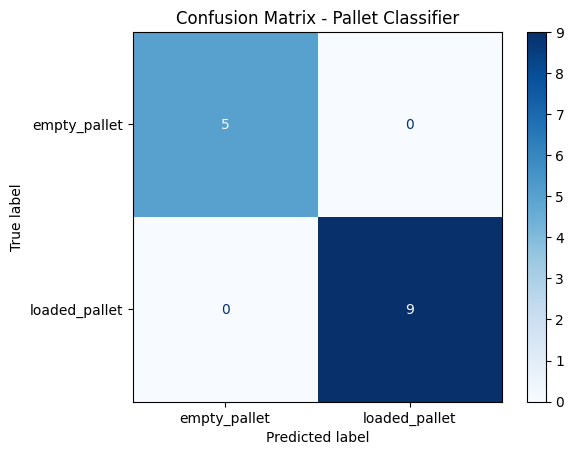

In [56]:
# Evaluation modelk for pallet classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load lại best model (phòng khi early stopping)
best_model = models.efficientnet_b0(pretrained=False)
num_ftrs = best_model.classifier[1].in_features
best_model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
best_model.load_state_dict(torch.load("pallet_classifier.pth", map_location=device))
best_model = best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = best_model(x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Vẽ ma trận
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Pallet Classifier")
plt.show()
